# Cropping the WWMR Pictures
**Ways to Wear a Mask or Respirator**


## Imports and Info

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image, ImageOps
import PIL
import os
import face_recognition

import cv2
import mediapipe as mp

In [2]:
mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils

In [3]:
# paths for the pictures from teh WWMR database
df_correct_root =  r'D:\data\face_mask\test\detected correct\\'
df_incorrect_root =  r'D:\data\face_mask\test\detected incorrect\\'

# intended dimensions of the output. 
target_h = 112
target_w = target_h  # enforce square


## Demonstration for 1 image

In [4]:
# test image for this demo
img_fp = r'./crop_test_imgs/145.png'
img_out_fp = r'./crop_test_imgs/145_out.png'


In [5]:
img = face_recognition.load_image_file(img_fp)

face_locs = face_recognition.face_locations(img)


with mp_face_detection.FaceDetection(
    model_selection=1, min_detection_confidence=0.5) as face_detection:
    
    image = cv2.imread(img_fp)
    results = face_detection.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))


In [6]:
for detection in results.detections:
    print(detection.location_data.relative_bounding_box)

xmin: 0.17116133868694305
ymin: 0.195454403758049
width: 0.5697441101074219
height: 0.4273484945297241



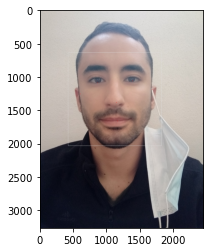

In [7]:
annotated_image = image.copy()
for detection in results.detections:
    mp_drawing.draw_detection(annotated_image, detection)
plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))


In [8]:
h, w, d = image.shape

rbb = detection.location_data.relative_bounding_box
rect_start_point = mp_drawing._normalized_to_pixel_coordinates(
  rbb.xmin, rbb.ymin, w,
  h)
rect_end_point = mp_drawing._normalized_to_pixel_coordinates(
  rbb.xmin + rbb.width,
  rbb.ymin + rbb.height, w,
  h)
# (x_left, y_top), (x_right, y_bot)
(rect_start_point, rect_end_point)

((419, 637), (1813, 2032))

Above are the coordinates of the face bounding box. The image shows the bounding box in white. Above that is the bounding box coordinates in normalized coordinates. 

We need to turn this rectangle into a square. The shorter of height or width will be expanded to longer of those two, creating a square. This does not garuntee that the square meets out output size garuntee. The resulting crop will need to be resampled to form an image of our target dimension output.

In [9]:
def correct_crop(xl, xr, yt, yb, w, h):
    if yt < 0:
        diff = abs(yt)
        yt = 0
        expand_left = int(diff / 2)
        expand_right = diff - expand_left
        xl = xl - expand_left
        xr = xr + expand_right
    if xl < 0:
        diff = abs(xl)
        xl = 0
        expand_down = int(diff / 2)
        expand_up = diff - expand_down
        yb = yb + expand_down
        yt = yt - expand_up
    if yb > h:
        diff = yb - h
        yb = h
        expand_left = int(diff / 2)
        expand_right = diff - expand_left
        xl = xl - expand_left
        xr = xr + expand_right
    if xr > w:
        diff = xr - w
        xr = w
        expand_down = int(diff / 2)
        expand_up = diff - expand_down
        yb = yb + expand_down
        yt = yt - expand_up
    if yt < 0 or xl < 0 or yb > h or xr > w:
        print('coords error after correction')
    return xl, xr, yt, yb

In [10]:
def rect_square_expansion(xl, xr, yt, yb, w, h):
    bbh = yb - yt
    bbw = xr - xl
    if bbh > bbw:
        diff = bbh - bbw
        expand_left = int(diff/2)
        expand_right = diff - expand_left
        xl = xl - expand_left
        xr = xr + expand_right
    elif bbw > bbh:
        diff = bbw - bbh
        expand_down = int(diff/2)
        expand_up = diff - expand_down
        yb = yb + expand_down
        yt = yt - expand_up
    
    return xl, xr, yt, yb

In [11]:
xl, yt = rect_start_point
xr, yb = rect_end_point
bbh = yb - yt
bbw = xr - xl
print('origional')
print('height: {}, width: {}'.format(bbh, bbw))

xl, xr, yt, yb = rect_square_expansion(xl, xr, yt, yb, w, h)
# if expansion push box out of image bounds, reduce size of box
xl, xr, yt, yb = correct_crop(xl, xr, yt, yb, w, h)

bbh = yb - yt
bbw = xr - xl
print('after')
print('height: {}, width: {}'.format(bbh, bbw))

origional
height: 1395, width: 1394
after
height: 1395, width: 1395


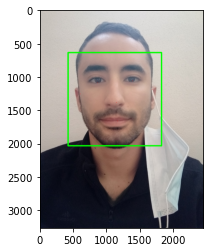

In [12]:
cv2.rectangle(annotated_image, (xl, yt), (xr, yb), (0,255,0),20)
plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))
# show square crop

In [13]:
"""
# optional expansion
expansion = .15
amt_to_add = int(expansion * max(width, height))

top = new_face_locs[0] - amt_to_add
bot = new_face_locs[2] + amt_to_add
left = new_face_locs[3] - amt_to_add
right = new_face_locs[1] + amt_to_add

if sum([x < 0 for x in [top, bot, right, left]]):
    print('dims out of bounds, reverting')

    top = new_face_locs[0]
    bot = new_face_locs[2]
    left = new_face_locs[3]
    right = new_face_locs[1]
"""
print()

In [14]:
# crop the image
pil_img = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))


# PIL crop format:  left, top, right, bottom
crop = [xl, yt, xr, yb]
pil_crop = pil_img.crop(crop)

In [15]:
# resize image
pil_crop = pil_crop.resize((target_h, target_w), resample=PIL.Image.Resampling.HAMMING)

In [16]:
# uncomment to show image in system default image viewer
#pil_crop.show()
pil_crop.save(img_out_fp)

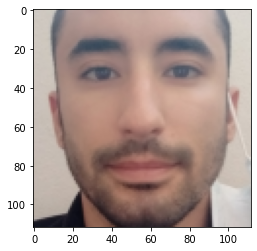

In [17]:
# display cropped image 
img = mpimg.imread(img_out_fp)
imgplot = plt.imshow(img)

Face crop, square, size is our target size. Looks good.


## Crop all

In [31]:
def face_crop_directory(in_directory, out_directory):
    counter = 0
                
    with mp_face_detection.FaceDetection(
        model_selection=1, min_detection_confidence=0.5) as face_detection:
        for root, subdirectories, files in os.walk(in_directory):
            for f in files:

                # load and recognize face
                og_img_path = os.path.join(root, f)
                image = cv2.imread(og_img_path)
                results = face_detection.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

                # get bounding box and image info
                h, w, d = image.shape
                rbb = detection.location_data.relative_bounding_box
                rect_start_point = mp_drawing._normalized_to_pixel_coordinates(
                  rbb.xmin, rbb.ymin, w,
                  h)
                rect_end_point = mp_drawing._normalized_to_pixel_coordinates(
                  rbb.xmin + rbb.width,
                  rbb.ymin + rbb.height, w,
                  h)
                xl, yt = rect_start_point
                xr, yb = rect_end_point
            
                # calculate crop
                xl, xr, yt, yb = rect_square_expansion(xl, xr, yt, yb, w, h)
                # if expansion push box out of image bounds, reduce size of box
                xl, xr, yt, yb = correct_crop(xl, xr, yt, yb, w, h)


                
                # expand if nessisary
                expansion = .125
                bbh = yb - yt
                bbw = xr - xl
                amt_to_add = int(expansion * max(bbh, bbw))
                yt = yt - amt_to_add
                yb = yb + amt_to_add
                xl = xl - amt_to_add
                xr = xr + amt_to_add
                
                # correct crop boundaries again if any expansion pushed crop outside image window
                xl, xr, yt, yb = correct_crop(xl, xr, yt, yb, w, h)
                

                # perform crop
                pil_img = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                # PIL crop format:  left, top, right, bottom
                crop = [xl, yt, xr, yb]
                pil_crop = pil_img.crop(crop)

                # resize
                pil_crop = pil_crop.resize((target_h, target_w), resample=PIL.Image.Resampling.HAMMING)

                # same image
                out_path = os.path.join(out_directory, f)
                pil_crop.save(out_path)

                if counter % 25 == 0:
                    print('processed: {}'.format(counter))
                counter += 1


In [25]:
df_correct_root = r'D:\data\face_mask\test\orig\correct'
df_incorrect_root = r'D:\data\face_mask\test\orig\incorrect'

out_crop_correct =  r'D:\data\face_mask\WWMR cropped MediaPipe\correct'
out_crop_incorrect =  r'D:\data\face_mask\WWMR cropped MediaPipe\incorrect'

In [33]:
face_crop_directory(df_correct_root, out_crop_correct)

processed: 0
processed: 25
processed: 50
processed: 75
processed: 100
processed: 125


In [32]:
face_crop_directory(df_incorrect_root, out_crop_incorrect)

processed: 0
processed: 25
processed: 50
processed: 75
processed: 100
processed: 125
processed: 150
processed: 175
processed: 200
processed: 225
processed: 250
processed: 275
processed: 300
processed: 325
processed: 350
processed: 375
processed: 400


With the face_recognition face detection, we were albe to scrape 343 images from this dataset. With mediapipe, we have 560 images. This is a massive increase from switching out one part of the whole datamining ML pipeline. The better face detection scheme will enable us to find more faces in test sets too.